##Our Task is to predict the coordinates of white boxes that appear against a black background

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [3]:
#Created and loaded model with input image of size (100,100,3) 
dim = 100 #pixels in image
cutoff = 80 #top-left coordinate pixel cutoff
image_size = (dim,dim,3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = tf.keras.Model(inputs=vgg.input, outputs=x)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [4]:
def get_image():
    x = np.zeros(image_size, dtype=float)  #image pixel value
    y = np.zeros(4, dtype=float)  #top-left coordinate and height and width, (row,col,height,width) within range [0,1]
    row0 = np.random.randint(0, cutoff)
    row1 = np.random.randint(row0+1, dim)
    col0 = np.random.randint(0, cutoff)
    col1 = np.random.randint(col0+1, dim)
    x[row0:row1,col0:col1,:] = 255 #creating white box
    y[0], y[1], y[2], y[3] = row0, col0, row1-row0, col1-col0
    return x, y

In [5]:
num_batches = 50
batch_size = 64
def my_generator():
    while True:
        for _ in range(num_batches):
            X = np.zeros((batch_size,) + image_size, dtype=float)
            Y = np.zeros((batch_size, 4), dtype=float)
            for i in range(batch_size):
                X[i],Y[i] = get_image()
            yield X/255.,Y/dim

In [6]:
model.compile(Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics='mse')
history = model.fit(my_generator(), epochs=10, steps_per_epoch=num_batches)

Epoch 1/10
50/50 [==============================] - 24s 181ms/step - loss: 0.5520 - mse: 0.0128
Epoch 2/10
50/50 [==============================] - 9s 182ms/step - loss: 0.5227 - mse: 4.7654e-04
Epoch 3/10
50/50 [==============================] - 9s 184ms/step - loss: 0.5214 - mse: 2.0770e-04
Epoch 4/10
50/50 [==============================] - 9s 185ms/step - loss: 0.5199 - mse: 1.7163e-04
Epoch 5/10
50/50 [==============================] - 9s 188ms/step - loss: 0.5207 - mse: 1.5288e-04
Epoch 6/10
50/50 [==============================] - 9s 189ms/step - loss: 0.5215 - mse: 1.1687e-04
Epoch 7/10
50/50 [==============================] - 10s 192ms/step - loss: 0.5191 - mse: 1.6922e-04
Epoch 8/10
50/50 [==============================] - 10s 195ms/step - loss: 0.5212 - mse: 1.6569e-04
Epoch 9/10
50/50 [==============================] - 10s 197ms/step - loss: 0.5195 - mse: 2.4372e-04
Epoch 10/10
50/50 [==============================] - 10s 199ms/step - loss: 0.5198 - mse: 8.3967e-05


In [7]:
def make_single_prediction():
    x,y = get_image()

    #Prediction of white box coordinates by model
    y_pred = model.predict(np.expand_dims(x/255., axis=0))[0]
    y_pred = np.array(np.round(y_pred*dim), dtype=int)

    #Plot predicted white box on image
    fig, ax = plt.subplots(1)
    ax.imshow(x/255.)
    rect = Rectangle((y_pred[1], y_pred[0]), y_pred[3], y_pred[2], edgecolor='r', facecolor='none', linewidth=1)
    ax.add_patch(rect)
    plt.show()

    #Computing Intersection over union
    y[2], y_pred[2] = y[0]+y[2], y_pred[0]+y_pred[2]
    y[3], y_pred[3] = y[1]+y[3], y_pred[1]+y_pred[3]
    common = max(0,min(y[2],y_pred[2])-max(y[0],y_pred[0]))*max(0,min(y[3],y_pred[3])-max(y[1],y_pred[1]))
    total_area = (y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1]) + (y[2]-y[0])*(y[3]-y[1]) - common
    iou = common/total_area
    print(f'Intersection over union : {round(iou,3)}')

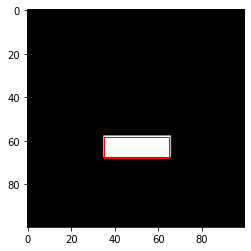

Intersection over union : 0.968


In [11]:
make_single_prediction()

In [9]:
def batch_prediction():
    #Generating batch of images
    X = np.zeros((batch_size,) + image_size, dtype=float)
    Y = np.zeros((batch_size, 4), dtype=float)
    for i in range(batch_size):
        X[i],Y[i] = get_image()
    y_pred = model.predict(X/255.)
    y_pred = np.round(y_pred*dim)

    #Computing intersection over union over batch of images
    height = np.maximum(np.minimum(Y[:,0]+Y[:,2],y_pred[:,0]+y_pred[:,2])-np.maximum(Y[:,0],y_pred[:,0]),0)
    width = np.maximum(np.minimum(Y[:,1]+Y[:,3],y_pred[:,1]+y_pred[:,3])-np.maximum(Y[:,1],y_pred[:,1]),0)
    common = height*width
    total = Y[:,2]*Y[:,3] + y_pred[:,2]*y_pred[:,3] - common
    iou = common/total
    return iou

Mean of Intersection over union over 64 batch images : 0.833
Standard deviation of Intersection over union over 64 batch images : 0.221


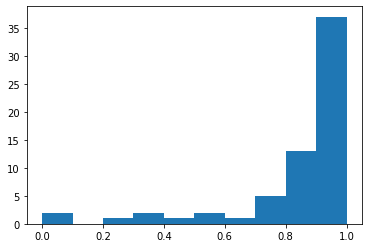

In [12]:
#Distribution of iou on single batch prediction
iou = batch_prediction()
plt.hist(iou, bins=10, range=(0,1))
print(f'Mean of Intersection over union over 64 batch images : {round(iou.mean(),3)}')
print(f'Standard deviation of Intersection over union over 64 batch images : {round(iou.std(),3)}')

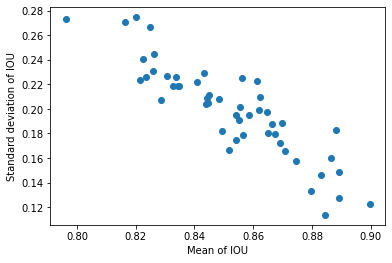

In [21]:
#Plotting how generalize our model is
iou_mean, iou_std = [],[]
for i in range(num_batches):
    iou = batch_prediction()
    iou_mean.append(iou.mean())
    iou_std.append(iou.std())
plt.xlabel('Mean of IOU')
plt.ylabel('Standard deviation of IOU')
plt.scatter(iou_mean, iou_std)